# Further Cleaning

This notebook was used for initial investigations into the data - with some basic plotting of descriptives
which highlighted issues with Duration values which required further cleaning.

In [1]:
# Imports 
import calendar
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
from datetime import datetime
from matplotlib.lines import Line2D  
from pandas.tools.plotting import scatter_matrix
from scipy import stats

In [2]:
# Library versions, for info
print ('Developed with the following library versions:')
print ('Matplotlib:\t\x1b[34m%s\x1b[0m' % (matplotlib.__version__))
print ('Numpy:\t\t\x1b[34m%s\x1b[0m' % (np.version.version))
print ('Python:\t\t\x1b[34m%s\x1b[0m' % (sys.version))
print ('Pandas:\t\t\x1b[34m%s\x1b[0m' % (pd.__version__))
print ('Seaborn:\t\x1b[34m%s\x1b[0m' % (sns.__version__))

Developed with the following library versions:
Matplotlib:	1.5.1
Numpy:		1.10.4
Python:		2.7.11 |Anaconda 4.0.0 (64-bit)| (default, Feb 16 2016, 09:58:36) [MSC v.1500 64 bit (AMD64)]
Pandas:		0.18.0
Seaborn:	0.7.1


In [3]:
# Date last worked on
datetime.now()

datetime.datetime(2017, 1, 19, 20, 30, 37, 680000)

In [5]:
# Directives, etc.
%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [6]:
# Top level declarations
journeys_data_file = 'D:\\cyclehire\\JourneyData2016.frame.csv'
stations_data_file = 'D:\\cyclehire\\stations.csv'

In [7]:
# Dict of data types to pass into read_csv
journeys_dtype = {
    'RentalId': int,
    'Duration': float, #to handle NAs
    'BikeId': int,
    'EndStationId': float, #to handle NAs
    'StartDateTime': int,
    'StartStationId': int,
    'HourOfDay': int,
    'MonthOfYear': int,
    'DayOfWeek':int,
    'DayOfYear': int,
    'StartLat': float,
    'StartLong': float,
    'EndLat': float,
    'EndLong': float,
    'Distance': float,
    'JourneyType': int,
    'Season': int,
    'NextStartStationId':float,
    'NextStartDateTime':float,
    'GapToNextJourney':float,
    'NextRentalId':float
}

# Read the file
journeys = pd.read_csv(
    journeys_data_file,
    index_col = 0,
    dtype = journeys_dtype)

# Sanity check
print ('shape: %s' % (str(journeys.shape)))
print ('dtypes:\n%s' % (str(journeys.dtypes)))

shape: (9454907, 21)
dtypes:
RentalId                int32
Duration              float64
BikeId                  int32
EndStationId          float64
StartDateTime           int32
StartStationId          int32
HourOfDay               int32
MonthOfYear             int32
DayOfWeek               int32
DayOfYear               int32
JourneyType             int32
Season                  int32
StartLat              float64
StartLong             float64
EndLat                float64
EndLong               float64
Distance              float64
NextStartStationId    float64
NextStartDateTime     float64
GapToNextJourney      float64
NextRentalId          float64
dtype: object


In [8]:
stations_cols = [
    'id',
    'name'
]

stations = pd.read_csv(
    stations_data_file,
    usecols = stations_cols
)

print ('shape: %s' % (str(stations.shape)))
print ('dtypes:\n%s' % (str(stations.dtypes)))

shape: (787, 2)
dtypes:
id       int64
name    object
dtype: object


In [9]:
# We'll need this to infer values for anomalous journey durations
medianDurations = journeys[["Distance","Duration"]].groupby("Distance").median()
def replaceDurationWithMedianForDistance(journey):
    ival = journey.name
    journeys.loc[ival,"Duration"] = float(medianDurations.iloc(journey.Distance)[0])

In [10]:
# Analyse zero duration journeys before removing them, is there any pattern here?
isZeroDuration = (journeys.Duration == 0) & (journeys.Distance == 0)
zeroDurationJourneys = journeys[isZeroDuration]
zeroDurationJourneys.head()

,RentalId,Duration,BikeId,EndStationId,StartDateTime,StartStationId,HourOfDay,MonthOfYear,DayOfWeek,DayOfYear,...,Season,StartLat,StartLong,EndLat,EndLong,Distance,NextStartStationId,NextStartDateTime,GapToNextJourney,NextRentalId
6871173,50608195,0.0,10779,291.0,1451606820,291,0,1,5,1,...,1,51.484840,-0.138089,51.484840,-0.138089,0.0,291.0,1.451607e+09,60.0,50608200.0
246523,50608246,0.0,373,338.0,1451607300,338,0,1,5,1,...,1,51.511850,-0.119640,51.511850,-0.119640,0.0,338.0,1.451608e+09,660.0,50608441.0
5428737,50608387,0.0,8590,100.0,1451607780,100,0,1,5,1,...,1,51.490436,-0.122807,51.490436,-0.122807,0.0,100.0,1.451608e+09,60.0,50608391.0
3191650,50608472,0.0,5159,387.0,1451607120,387,0,1,5,1,...,1,51.493700,-0.121394,51.493700,-0.121394,0.0,387.0,1.451609e+09,2340.0,50608901.0
152286,50609681,0.0,235,570.0,1451613180,570,1,1,5,1,...,1,51.503083,-0.017676,51.503083,-0.017676,0.0,547.0,1.451986e+09,373140.0,50660904.0


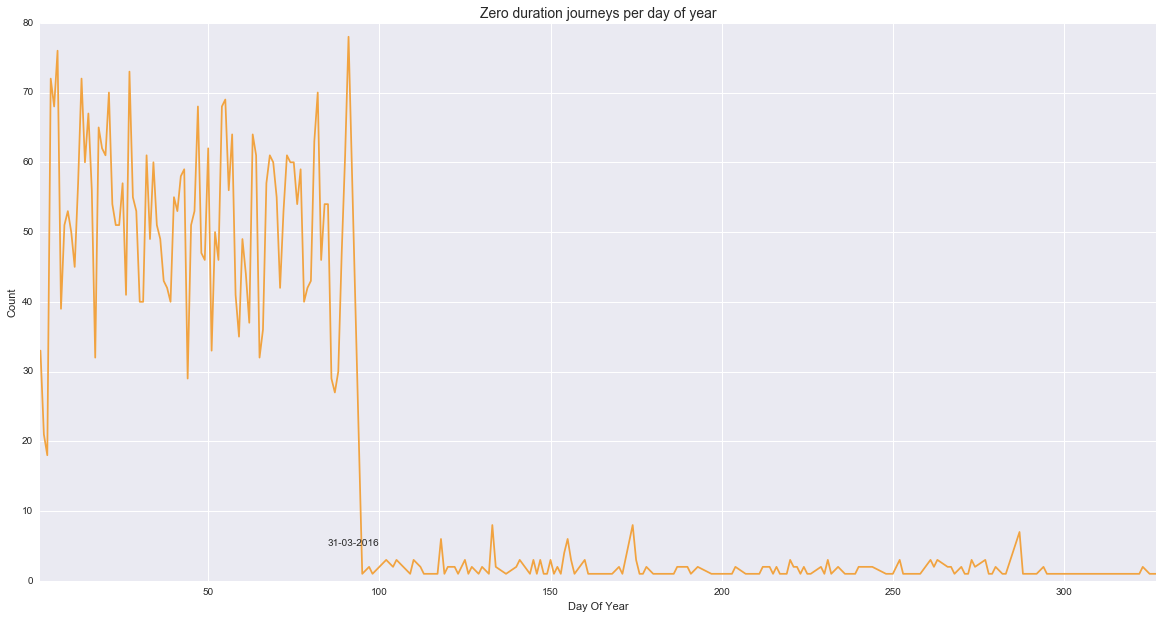

In [11]:
plotdata = zeroDurationJourneys[["DayOfYear", "Duration"]].groupby(["DayOfYear"]).count()
figure, ax = plt.subplots(1,1, figsize=(20,10))
ax.plot(plotdata.index.values, plotdata.Duration, color='#f1a340')
plt.xlabel("Day Of Year")
plt.ylabel("Count")
plt.xlim(1, max(plotdata.index.values))
plt.title("Zero duration journeys per day of year", fontsize=14)
plt.gca().text(85, 5, "31-03-2016", fontsize=10) 
plt.show() 

In [12]:
# 31st March seems to be the point where the count drops off
cutoffDay = plotdata[plotdata.Duration > 10].index.max()
cutoffTs = zeroDurationJourneys[zeroDurationJourneys.DayOfYear == cutoffDay][-1:].StartDateTime
print("Cutoff (day %d): %s" % (cutoffDay, datetime.fromtimestamp(cutoffTs)))

Cutoff (day 91): 2016-03-31 23:12:00


In [13]:
# Create two subsets of data for our categories, and see if we can find out anything about them
isHighZeroDurationJourneys = zeroDurationJourneys.DayOfYear < 92
highZeroDurationJourneys = zeroDurationJourneys[isHighZeroDurationJourneys]
lowZeroDurationJourneys = zeroDurationJourneys[-isHighZeroDurationJourneys]

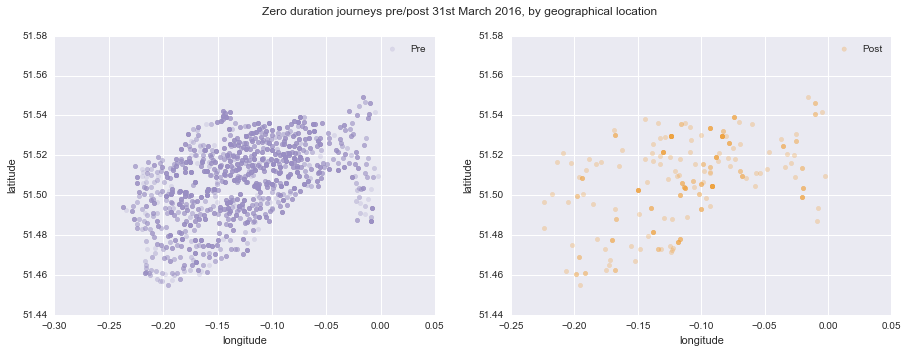

In [14]:
# We don't have much to go on, in terms of why there should have been a drop-off in
# zero duration journeys after 31st March, but let's check by geo-coordinates and see
# if there is any pattern to physical location of start station.
# Spoiler alert: not obviously. (although some evidence with low alpha orange; but could this be because popular 
# location? - need some kind of count by start lat to confirm)
fig = plt.figure(figsize=(15,5))    
ax = fig.add_subplot(121)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.scatter(
    x=highZeroDurationJourneys.StartLong, 
    y=highZeroDurationJourneys.StartLat,   
    alpha=0.2,
    color="#998ec3",
    label="Pre"
)
plt.legend()
ax = fig.add_subplot(122)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.scatter(
    x=lowZeroDurationJourneys.StartLong, 
    y=lowZeroDurationJourneys.StartLat,
    alpha=0.3,
    color="#f1a340",
    label="Post"
)
plt.suptitle("Zero duration journeys pre/post 31st March 2016, by geographical location")
plt.legend()
plt.show()

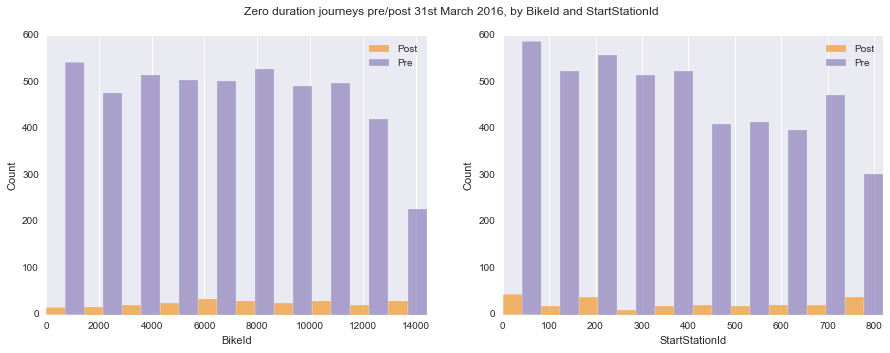

In [15]:
# Did we maybe get an influx of new bikes (assuming that these would have been assigned
# higher BikeId values). Nope.
fig = plt.figure(figsize=(15,5))    
ax = fig.add_subplot(121)
ax.hist([lowZeroDurationJourneys.BikeId, highZeroDurationJourneys.BikeId], 
    label=['Post', 'Pre'], rwidth=1, color=['#f1a340', '#998ec3'], alpha=0.8)
plt.legend(loc="upper right")
plt.ylabel('Count')
plt.xlabel('BikeId')
plt.gca().yaxis.grid(which='both')
plt.xlim(0, max(zeroDurationJourneys.BikeId))
ax = fig.add_subplot(122)
ax.hist([lowZeroDurationJourneys.StartStationId, highZeroDurationJourneys.StartStationId], 
    label=['Post', 'Pre'], rwidth=1, color=['#f1a340', '#998ec3'], alpha=0.8)
plt.legend(loc="upper right")
plt.ylabel('Count')
plt.xlabel('StartStationId')
plt.gca().yaxis.grid(which='both')
plt.xlim(0, max(zeroDurationJourneys.StartStationId))
plt.suptitle("Zero duration journeys pre/post 31st March 2016, by BikeId and StartStationId")
plt.show()

In [16]:
# Remove any journeys with Duration == 0 and Distance == 0
print("Removing %d zero duration journeys" %(len(isZeroDuration[isZeroDuration])))
journeys.drop(journeys[isZeroDuration].index, inplace=True)

Removing 4962 zero duration journeys


In [17]:
# We still have some zero durations, but these have distances so we can infer duration
isZeroDuration = journeys.Duration == 0 
zeroDurationJourneys = journeys[isZeroDuration]
zeroDurationJourneys.shape

(166, 21)

In [18]:
print("Updating %d zero durations with median values" %(len(isZeroDuration[isZeroDuration])))
zeroDurationJourneys.apply(replaceDurationWithMedianForDistance, axis=1)
isZeroDuration = journeys.Duration == 0 
zeroDurationJourneys = journeys[isZeroDuration]
zeroDurationJourneys.shape        

Updating 166 zero durations with median values


(0, 21)

In [19]:
# Also drop anything with duration over one day, as that's supposed to be the limit
oneDay = 60*60*24
isLongerThanOneDay = journeys.Duration > oneDay
longerThanOneDayJourneys = journeys[(isLongerThanOneDay)]
longerThanOneDayJourneys.head()

,RentalId,Duration,BikeId,EndStationId,StartDateTime,StartStationId,HourOfDay,MonthOfYear,DayOfWeek,DayOfYear,...,Season,StartLat,StartLong,EndLat,EndLong,Distance,NextStartStationId,NextStartDateTime,GapToNextJourney,NextRentalId
5548393,50608543,390960.0,8784,161.0,1451608320,193,0,1,5,1,...,1,51.505818,-0.100186,51.492346,-0.141334,3.221864,161.0,1.452676e+09,676740.0,50823152.0
2763928,50608565,126300.0,4458,532.0,1451608380,193,0,1,5,1,...,1,51.505818,-0.100186,51.503570,-0.020068,5.557113,532.0,1.451779e+09,44160.0,50626250.0
5414749,50609180,222600.0,8565,21.0,1451610720,64,1,1,5,1,...,1,51.509462,-0.124749,51.530078,-0.138846,2.494089,21.0,1.451833e+09,0.0,50628876.0
7030007,50609376,242580.0,10991,462.0,1451611500,546,1,1,5,1,...,1,51.517428,-0.107987,51.541603,-0.138853,3.436787,462.0,1.451931e+09,76800.0,50648113.0
5817731,50609523,117720.0,9186,357.0,1451612220,299,1,1,5,1,...,1,51.493985,-0.136929,51.520994,-0.139016,3.010082,357.0,1.451748e+09,18420.0,50623440.0


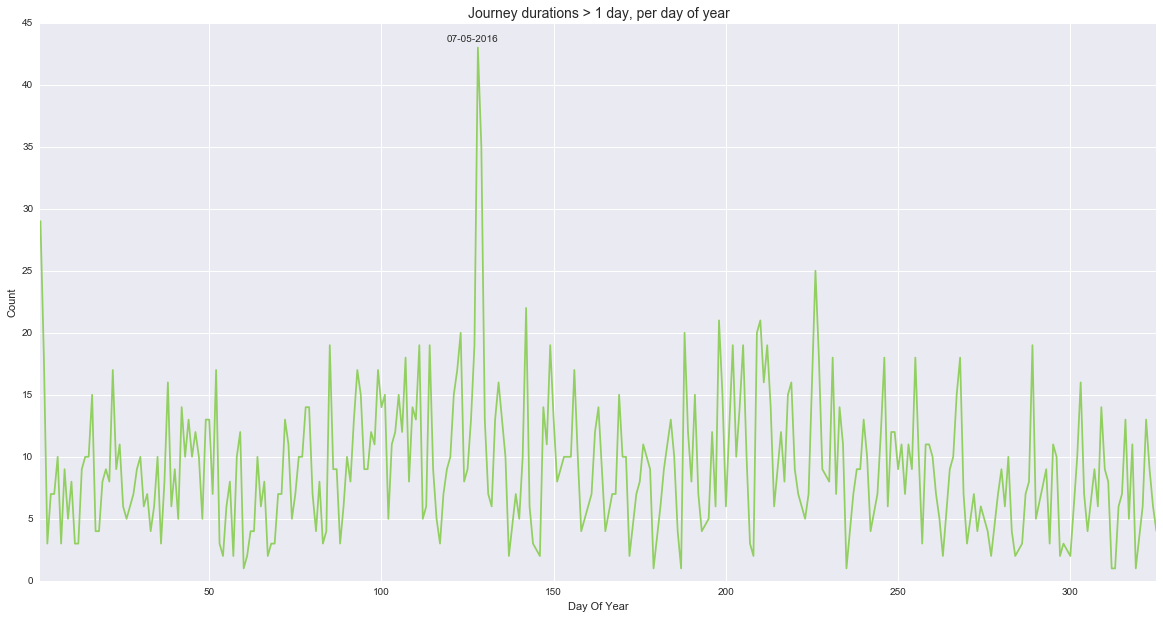

In [20]:
plotdata = longerThanOneDayJourneys[["DayOfYear", "Duration"]].groupby(["DayOfYear"]).count()
figure, ax = plt.subplots(1,1, figsize=(20,10))
ax.plot(plotdata.index.values, plotdata.Duration, color='#91cf60')
plt.xlabel("Day Of Year")
plt.ylabel("Count")
plt.xlim(1, max(plotdata.index.values))
plt.title("Journey durations > 1 day, per day of year", fontsize=14)
plt.gca().text(119, 43.5, "07-05-2016", fontsize=10) 
plt.show() 

In [21]:
# 7th July seems to be the main spike - Saturday. Suggests maybe TFL maintenance
cutoffDay = plotdata[plotdata.Duration > 40].index.max()
cutoffTs = longerThanOneDayJourneys[longerThanOneDayJourneys.DayOfYear == cutoffDay][-1:].StartDateTime
print("Cutoff (day %d): %s" % (cutoffDay, datetime.fromtimestamp(cutoffTs)))

Cutoff (day 128): 2016-05-07 23:47:00


In [29]:
# Remove any journeys with Duration > 1 day
print("Removing %d duration > 1 day journeys" %(len(isLongerThanOneDay[isLongerThanOneDay])))
journeys.drop(journeys[isLongerThanOneDay].index, inplace=True)

Removing 2850 duration > 1 day journeys


In [30]:
journeys["Speed"] = (journeys.Distance / journeys.Duration) * 3600

In [31]:
journeys.sort_values(by="Speed", ascending=False).head()

,RentalId,Duration,BikeId,EndStationId,StartDateTime,StartStationId,HourOfDay,MonthOfYear,DayOfWeek,DayOfYear,...,StartLat,StartLong,EndLat,EndLong,Distance,NextStartStationId,NextStartDateTime,GapToNextJourney,NextRentalId,Speed
3398667,59324385,60.0,5494,626.0,1476210720,193,19,10,2,285,...,51.505818,-0.100186,51.484387,-0.204815,7.633726,626.0,1.476259e+09,47880.0,59334803.0,458.023585
1452828,58248028,60.0,2354,152.0,1473615600,497,18,9,7,255,...,51.526177,-0.027468,51.492170,-0.101537,6.377042,152.0,1.473673e+09,57780.0,58270426.0,382.622520
3927631,54765490,60.0,6330,33.0,1465584780,191,19,6,5,162,...,51.503118,-0.153521,51.515600,-0.070056,5.947365,33.0,1.465593e+09,8160.0,54770413.0,356.841924
434958,58279279,60.0,669,130.0,1473693420,303,16,9,1,256,...,51.502954,-0.158456,51.509506,-0.075459,5.796796,130.0,1.473705e+09,11760.0,58291515.0,347.807738
1920000,52350019,60.0,3096,711.0,1458676740,395,19,3,2,82,...,51.492462,-0.159919,51.483357,-0.216306,4.037801,711.0,1.458821e+09,143880.0,52391605.0,242.268058


In [32]:
print("start: %s" %(stations[stations.id == 193].name))
print("end: %s" %(stations[stations.id == 626].name))
# Google maps says is 6.5 mile journey, so data says was done in 60 secs. Which is clearly nonsese.

start: 3    Bankside Mix, Bankside
Name: name, dtype: object
end: 641    Normand Park, West Kensington
Name: name, dtype: object


In [34]:
threeStdDev = journeys.Speed.std() * 3
maxLikelySpeed = journeys.Speed.mean() + threeStdDev
isUnlikelyJourneySpeed = journeys.Speed > maxLikelySpeed
print("mean speed plus 3*stddev = %f kmh" % (maxLikelySpeed))
unlikelyJourneys = journeys[isUnlikelyJourneySpeed]
print("num unlikely fast journeys: %d" % (len(unlikelyJourneys.Speed)))
unlikelyJourneys.sort_values(by="Speed", ascending=False).head()


mean speed plus 3*stddev = 20.604677 kmh
num unlikely fast journeys: 11033


,RentalId,Duration,BikeId,EndStationId,StartDateTime,StartStationId,HourOfDay,MonthOfYear,DayOfWeek,DayOfYear,...,StartLat,StartLong,EndLat,EndLong,Distance,NextStartStationId,NextStartDateTime,GapToNextJourney,NextRentalId,Speed
3398667,59324385,60.0,5494,626.0,1476210720,193,19,10,2,285,...,51.505818,-0.100186,51.484387,-0.204815,7.633726,626.0,1.476259e+09,47880.0,59334803.0,458.023585
1452828,58248028,60.0,2354,152.0,1473615600,497,18,9,7,255,...,51.526177,-0.027468,51.492170,-0.101537,6.377042,152.0,1.473673e+09,57780.0,58270426.0,382.622520
3927631,54765490,60.0,6330,33.0,1465584780,191,19,6,5,162,...,51.503118,-0.153521,51.515600,-0.070056,5.947365,33.0,1.465593e+09,8160.0,54770413.0,356.841924
434958,58279279,60.0,669,130.0,1473693420,303,16,9,1,256,...,51.502954,-0.158456,51.509506,-0.075459,5.796796,130.0,1.473705e+09,11760.0,58291515.0,347.807738
1920000,52350019,60.0,3096,711.0,1458676740,395,19,3,2,82,...,51.492462,-0.159919,51.483357,-0.216306,4.037801,711.0,1.458821e+09,143880.0,52391605.0,242.268058


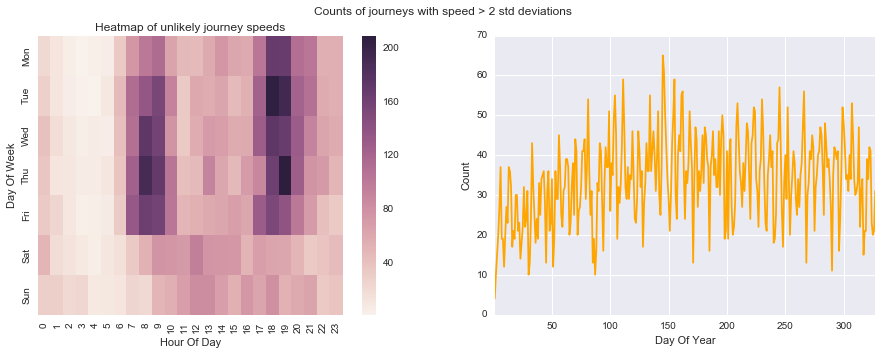

In [35]:
plotdata = unlikelyJourneys[["DayOfWeek", "HourOfDay", "Duration"]].groupby(["DayOfWeek","HourOfDay"]).count()
fig = plt.figure(figsize=(15,5))    
ax = fig.add_subplot(121)
axes = sns.heatmap(plotdata.unstack(), fmt="d", ax=ax)
plt.xlabel('Hour Of Day')
plt.ylabel('Day Of Week')
axes.yaxis.set_ticklabels(["Sun","Sat","Fri","Thu","Wed","Tue","Mon"])
axes.xaxis.set_ticklabels(range(0,24))
plt.title("Heatmap of unlikely journey speeds")
ax = fig.add_subplot(122)
plotdata = unlikelyJourneys[["DayOfYear", "Distance"]].groupby(["DayOfYear"]).count()
ax.plot(plotdata.index.values, plotdata.Distance, color='orange')
plt.xlabel("Day Of Year")
plt.ylabel("Count")
plt.xlim(1, max(plotdata.index.values))
plt.suptitle("Counts of journeys with speed > 2 std deviations")
plt.show()

In [36]:
# Recalculate duration for any unlikely fast journeys
print("Updating %d unlikely journey speeds" %(len(isUnlikelyJourneySpeed[isUnlikelyJourneySpeed])))
tmp = unlikelyJourneys.apply(replaceDurationWithMedianForDistance, axis=1)

Updating 11033 unlikely journey speeds


In [37]:
# recalculate speed based on updated durations
journeys["Speed"] = (journeys.Distance / journeys.Duration) * 3600
isUnlikelyJourneySpeed = journeys.Speed > maxLikelySpeed
unlikelyFastJourneys = journeys[isUnlikelyJourneySpeed]
unlikelyFastJourneys.sort_values(by="Speed", ascending=False).head()

,RentalId,Duration,BikeId,EndStationId,StartDateTime,StartStationId,HourOfDay,MonthOfYear,DayOfWeek,DayOfYear,...,StartLat,StartLong,EndLat,EndLong,Distance,NextStartStationId,NextStartDateTime,GapToNextJourney,NextRentalId,Speed
1101724,58028595,1920.0,1785,690.0,1473099540,790,19,9,1,249,...,51.541793,-0.00481,51.470475,-0.15213,12.931539,690.0,1.473112e+09,11880.0,58035342.0,24.246636


In [38]:
journeys.to_csv("D:\\cyclehire\\JourneyData2016.frame2.csv")